## **IMPORT LIBRARIES**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)          
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import math 
import warnings # Supress warnings 
warnings.filterwarnings('ignore')
import gdown
import tensorflow as tf
import argparse
import imutils
import cv2
import os
# plt.rcParams.update({'font.size': 14})
warnings.filterwarnings('ignore')
from matplotlib import style 
import datetime as dt
style.use("ggplot")

2022-10-31 16:06:28.755924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 16:06:29.279760: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 16:06:30.392572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-10-31 16:06:30.392826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

## **READING THE DATA**

In [2]:
# To download the test drive data  from the google drive
# url = "https://drive.google.com/drive/folders/16htJCKfYkvl1AbcUx7OTVwKVyH16CxHv?usp=sharing"
# gdown.download_folder(url, quiet=True, use_cookies=False)

In [3]:
# load test drive data to do preprocessing on it 
test_drive_df=pd.read_excel('/home/ahmed/queens_project/final_project/data/DEBI Dataset (1).xlsx') 

In [4]:
# Show the head of loaded data 
test_drive_df.head()

,All-Latitude,All-Longitude,All-ServingCellRSRP(dBm)[1],All-ServingCellRSRQ(dB)[1],All-ServingCellRSSI(dBm)[1],serving Lat,serving Long,distance
0,30.01471,31.45804,-66.5625,-9.7500,-39.8125,30.010772,31.456667,0.456179
1,30.01472,31.45804,-66.5625,-9.7500,-39.8125,30.010772,31.456667,0.457239
2,30.01472,31.45805,-66.5625,-9.7500,-39.8125,30.010772,31.456667,0.457520
3,30.01472,31.45806,-66.8125,-12.6875,-35.7500,30.010772,31.456667,0.457802
4,30.01472,31.45807,-67.3125,-14.1250,-36.1875,30.010772,31.456667,0.458086


In [5]:
# After we read dataset description we found that these columns not needed  
test_drive_df.drop(columns=['All-ServingCellRSRQ(dB)[1]','All-ServingCellRSSI(dBm)[1]'],inplace=True)

In [6]:
# Change columns name 
test_drive_df.columns = ['Rec_Lat', 'Rec_Long', 'RSRP', 'serving_Lat','serving_Long','distance']  # type: ignore

In [7]:
# Show the head of the loaded data 
test_drive_df.head()

,Rec_Lat,Rec_Long,RSRP,serving_Lat,serving_Long,distance
0,30.01471,31.45804,-66.5625,30.010772,31.456667,0.456179
1,30.01472,31.45804,-66.5625,30.010772,31.456667,0.457239
2,30.01472,31.45805,-66.5625,30.010772,31.456667,0.457520
3,30.01472,31.45806,-66.8125,30.010772,31.456667,0.457802
4,30.01472,31.45807,-67.3125,30.010772,31.456667,0.458086


## **EDA**

In [8]:
# Describe dataset 
test_drive_df.describe()

,Rec_Lat,Rec_Long,RSRP,serving_Lat,serving_Long,distance
count,86904.000000,86904.000000,86311.000000,86904.000000,86904.000000,86904.000000
mean,30.010833,31.456929,-82.199889,30.010624,31.456981,0.316782
std,0.007328,0.006574,9.340947,0.007623,0.006774,0.172643
min,29.999150,31.445830,-113.875000,29.998269,31.437775,0.002481
25%,30.004210,31.451570,-88.750000,30.003575,31.452244,0.192972
50%,30.009950,31.456660,-81.437500,30.010572,31.456667,0.292807
75%,30.016790,31.461430,-75.312500,30.016964,31.461689,0.401971
max,30.025250,31.474660,-54.875000,30.029353,31.481494,1.618948


In [9]:
# Show dataset shape 
test_drive_df.shape

(86904, 6)

In [10]:
# Check null values 
test_drive_df.isnull().sum()

Rec_Lat           0
Rec_Long          0
RSRP            593
serving_Lat       0
serving_Long      0
distance          0
dtype: int64

As we see, there are 593 missing values in the RSRP column.
We handled that by replacing them with previous value for RSRP

In [11]:
# make fill with previous  value for each row 
# test_drive_df.dropna(subset=['RSRP'],axis=0 , inplace=True)
test_drive_df["RSRP"].fillna( method ='ffill', inplace = True)

In [12]:
# Check null values after we filled it 
test_drive_df.isnull().sum()

Rec_Lat         0
Rec_Long        0
RSRP            0
serving_Lat     0
serving_Long    0
distance        0
dtype: int64

In [13]:
# Print a concise summary of a DataFrame
test_drive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86904 entries, 0 to 86903
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rec_Lat       86904 non-null  float64
 1   Rec_Long      86904 non-null  float64
 2   RSRP          86904 non-null  float64
 3   serving_Lat   86904 non-null  float64
 4   serving_Long  86904 non-null  float64
 5   distance      86904 non-null  float64
dtypes: float64(6)
memory usage: 4.0 MB


## **Measure Bearing angle** 

Bearing or azimuth is the horizontal angle between the direction of an object and north or another object. A bearing measured clockwise from the north direction

In [14]:
from turfpy import measurement
from geojson import Point, Feature

In [15]:
# Function to measure Bearing angle 
def cal_bearing(L1,Lo1,L2,Lo2):
    start = Feature(geometry=Point((L1,Lo1)))
    end = Feature(geometry=Point((L2,Lo2)))
    bearing=measurement.bearing(start,end)
    return bearing

In [16]:
# Run "cal_bearing" function on the dataset
bearing_ang=[]
for i in test_drive_df.index:
   bearing_ang.append(cal_bearing(test_drive_df['Rec_Lat'][i],
                                        test_drive_df['Rec_Long'][i],
                                        test_drive_df['serving_Lat'][i],
                                        test_drive_df['serving_Long'][i]))

In [17]:
# Save bearing angle values in the dataset
test_drive_df['Bearing_angle']= bearing_ang

To check the value of bearing angle we use the below link

https://www.igismap.com/map-tool/bearing-angle


bearing angle igis maps

In [18]:
test_drive_df.head()

,Rec_Lat,Rec_Long,RSRP,serving_Lat,serving_Long,distance,Bearing_angle
0,30.01471,31.45804,-66.5625,30.010772,31.456667,0.456179,-112.230030
1,30.01472,31.45804,-66.5625,30.010772,31.456667,0.457239,-112.179183
2,30.01472,31.45805,-66.5625,30.010772,31.456667,0.457520,-112.324916
3,30.01472,31.45806,-66.8125,30.010772,31.456667,0.457802,-112.470345
4,30.01472,31.45807,-67.3125,30.010772,31.456667,0.458086,-112.615469


## **Measure Path Loss**

Path Loss (PL) Path loss (or path attenuation) delineates a decline in power density of any given electromagnetic wave as it propagates through space.

In [19]:
def PL_Hata(
    d: float, fc: float = 2100, hrx: float = 1.5, htx: float = 45):
    """
    Hata path loss model, for large scale coverage
    :fc : Carrier frequency 
    :d : Distance between Tx and Rx (in km)
    :hrx: height of receiving antenna
    :htx : height of transmitting antenna
    Out: PL: pathloss (dB)
    """
    #caculate a(hre) is the correction factor for receiver antenna heights
    C_rx = 0.8 + (1.1 * np.log10(fc) - 0.7) * hrx - 1.56 * np.log10(fc)
    #caculate path loss using Okumura-Hata Model
    PL = ( 69.55 + 26.16 * np.log10(fc) - 13.82 * np.log10(htx) - C_rx + (44.9 - 6.55 * np.log10(htx)) * np.log10(d) )
    return PL

In [20]:
# run "PL_Hata" function 
Path_loss=[]
for i in test_drive_df.index:
   Path_loss.append(PL_Hata(test_drive_df['distance'][i]))  # type: ignore

https://www.rfwireless-world.com/calculators/Hata-model-path-loss-calculator.html


Hata model path loss calculator | Hata model path loss formula

In [21]:
# Save Path_loss in the dataset
test_drive_df['PL']= Path_loss

In [22]:
test_drive_df

,Rec_Lat,Rec_Long,RSRP,serving_Lat,serving_Long,distance,Bearing_angle,PL
0,30.01471,31.45804,-66.5625,30.010772,31.456667,0.456179,-112.230030,121.949087
1,30.01472,31.45804,-66.5625,30.010772,31.456667,0.457239,-112.179183,121.983458
2,30.01472,31.45805,-66.5625,30.010772,31.456667,0.457520,-112.324916,121.992532
3,30.01472,31.45806,-66.8125,30.010772,31.456667,0.457802,-112.470345,122.001660
4,30.01472,31.45807,-67.3125,30.010772,31.456667,0.458086,-112.615469,122.010843
...,...,...,...,...,...,...,...,...
86899,30.00200,31.46485,-76.8750,30.002019,31.461689,0.305004,179.706241,115.992408
86900,30.00200,31.46486,-76.8750,30.002019,31.461689,0.305969,179.707167,116.039142
86901,30.00200,31.46487,-76.6875,30.002019,31.461689,0.306934,179.708088,116.085728
86902,30.00200,31.46488,-79.3750,30.002019,31.461689,0.307899,179.709002,116.132169


# **Data Visualization**

<AxesSubplot: >

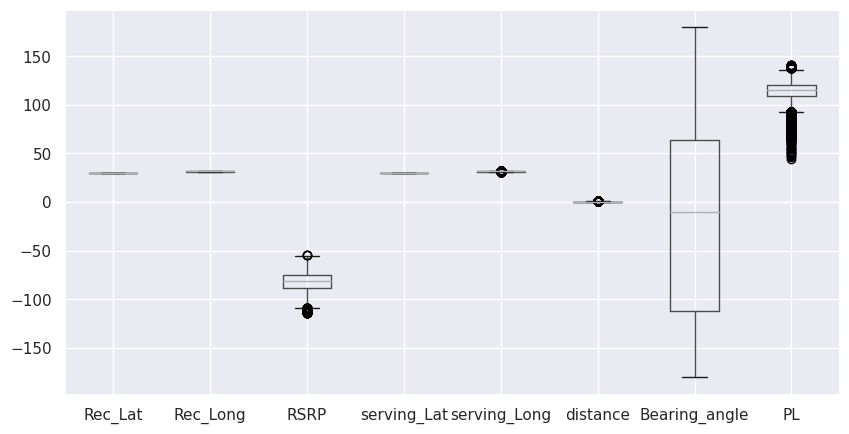

In [34]:
#Outliars
plt.figure(figsize = (10, 5)) 
test_drive_df.boxplot()

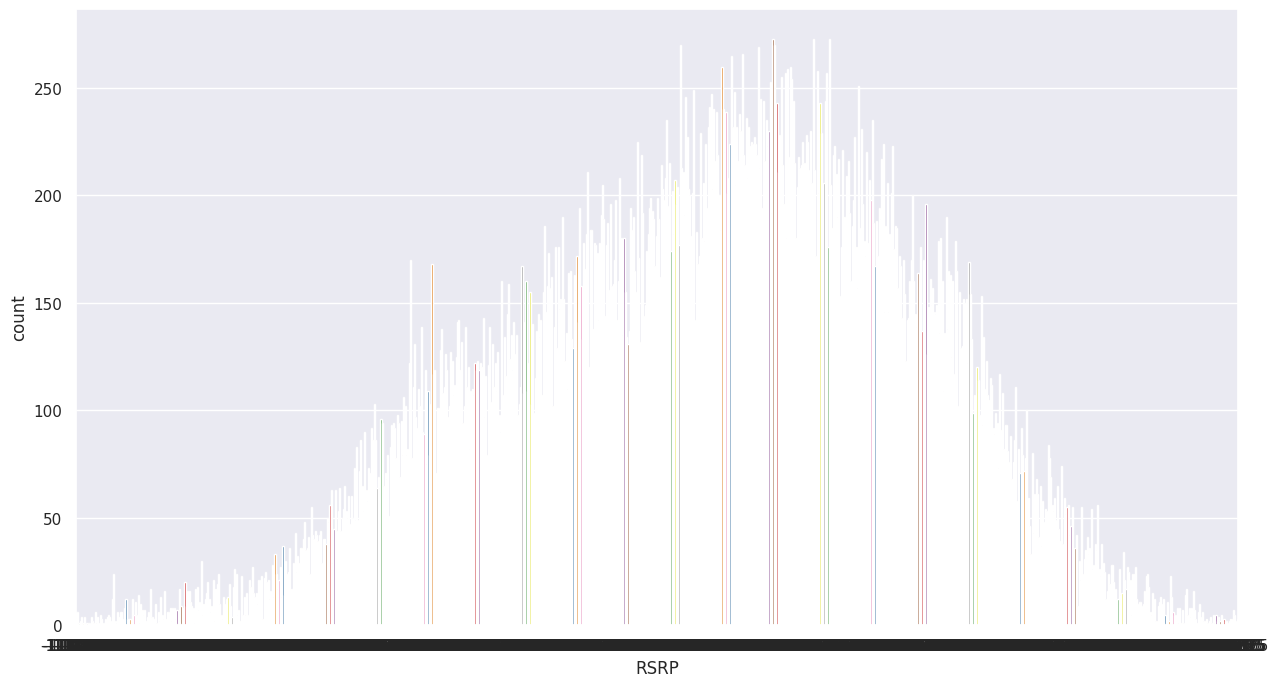

In [35]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(x="RSRP", data=test_drive_df, palette="Set1")
plt.show()

Text(0, 0.5, 'RSRP')

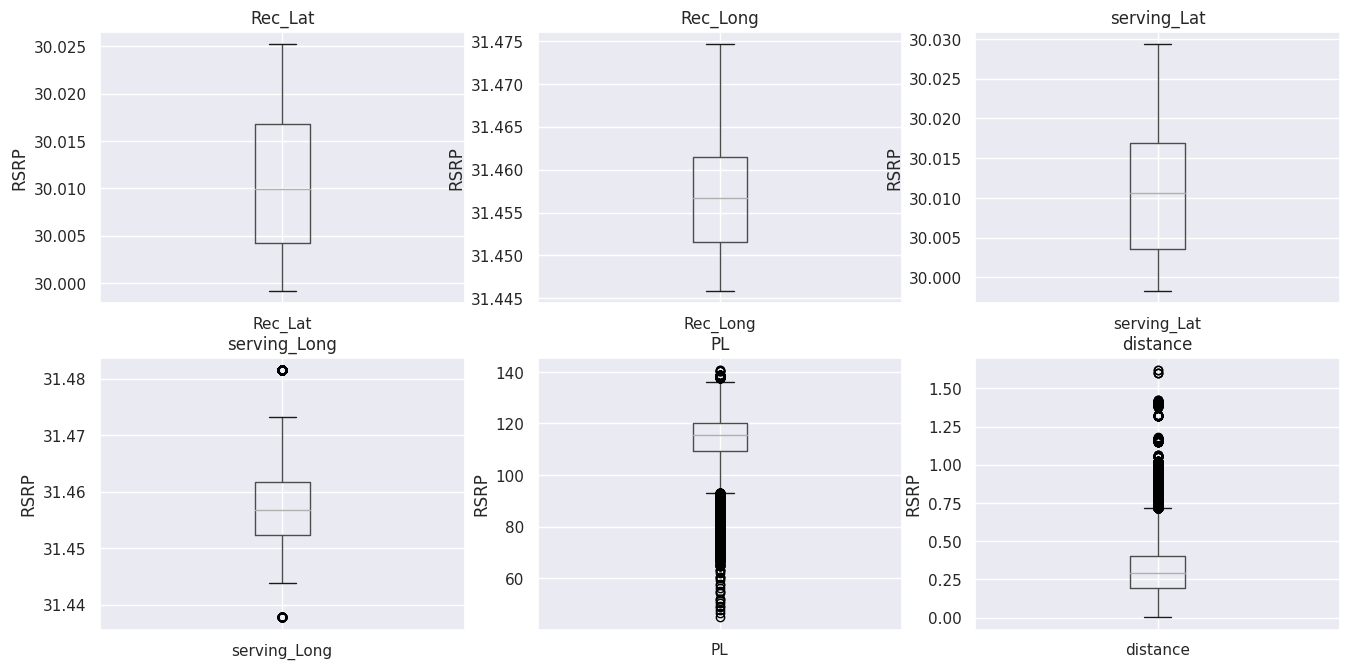

In [36]:
# draw boxplots to visualize outliers

plt.figure(figsize=(16,12))


plt.subplot(3, 3, 1)
fig = test_drive_df.boxplot(column='Rec_Lat')
fig.set_title('Rec_Lat')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 2)
fig = test_drive_df.boxplot(column='Rec_Long')
fig.set_title('Rec_Long')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 3)
fig =test_drive_df.boxplot(column='serving_Lat')
fig.set_title('serving_Lat')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 4)
fig = test_drive_df.boxplot(column='serving_Long')
fig.set_title('serving_Long')
fig.set_ylabel('RSRP')


plt.subplot(3,3,5)
fig = test_drive_df.boxplot(column='PL')
fig.set_title('PL')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 6)
fig = test_drive_df.boxplot(column='distance')
fig.set_title('distance')
fig.set_ylabel('RSRP')

Text(0, 0.5, 'RSRP')

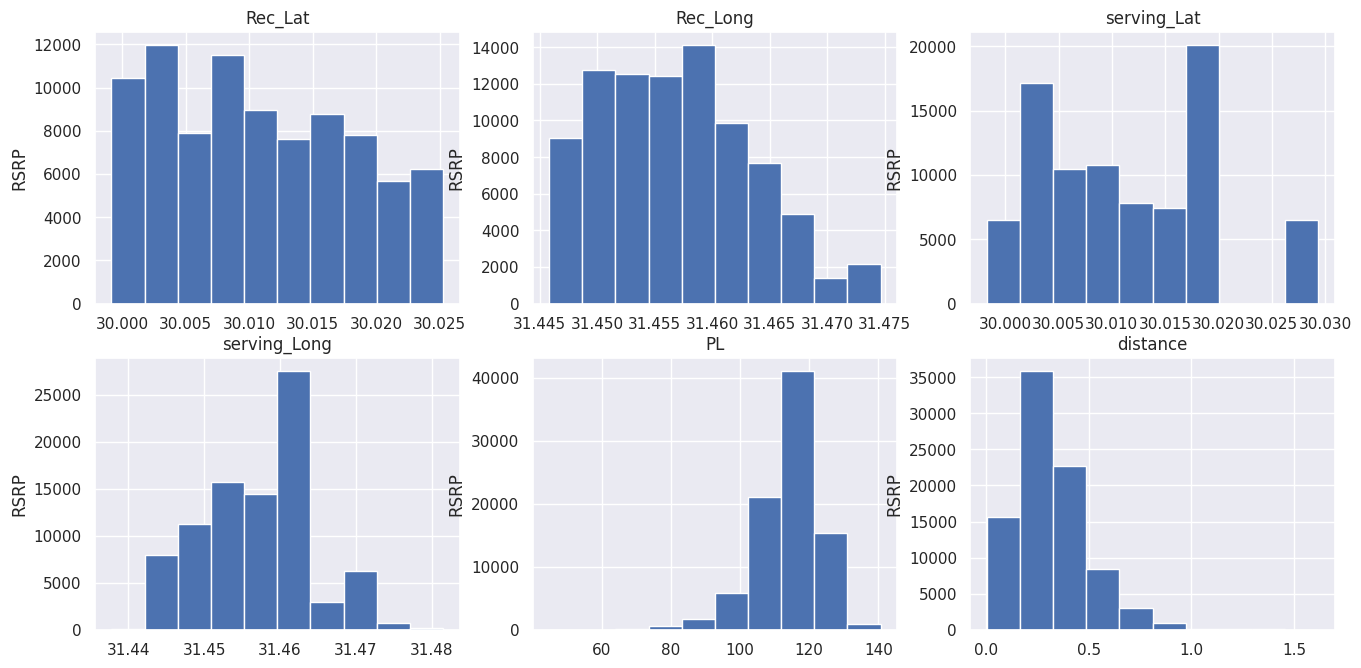

In [37]:
# plot histogram to check distribution
plt.figure(figsize=(16,12))


plt.subplot(3, 3, 1)
fig = test_drive_df.Rec_Lat.hist(bins=10)
fig.set_title('Rec_Lat')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 2)
fig = test_drive_df.Rec_Long.hist(bins=10)
fig.set_title('Rec_Long')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 3)
fig =test_drive_df.serving_Lat.hist(bins=10)
fig.set_title('serving_Lat')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 4)
fig = test_drive_df.serving_Long.hist(bins=10)
fig.set_title('serving_Long')
fig.set_ylabel('RSRP')


plt.subplot(3,3,5)
fig = test_drive_df.PL.hist(bins=10)
fig.set_title('PL')
fig.set_ylabel('RSRP')


plt.subplot(3, 3, 6)
fig = test_drive_df.distance.hist(bins=10)
fig.set_title('distance')
fig.set_ylabel('RSRP')

# **Data Augmentation**

We made data augmentation to add more rows.

We use Rec_Lat and Rec_Long and add 0.00005 on the receiver location  and use the same images to the new rows.

So, based on the change in receiver location the distance between transmitter and receiver, path loss and bearing angle will change  

In [25]:
Rec_Lat=test_drive_df["Rec_Lat"]
Rec_Long=test_drive_df["Rec_Long"]

In [26]:
# Measure distance between rec location and transmitter  
def cal_distance(L1,Lo1,L2,Lo2):
    start = Feature(geometry=Point((L1,Lo1)))
    end = Feature(geometry=Point((L2,Lo2)))
    distance=measurement.distance(start,end)
    return distance

In [27]:
# Save the new data in df 
df= pd.DataFrame()
df["Rec_Lat"] = Rec_Lat+0.00005
df["Rec_Long"]= Rec_Long+0.00005
df["RSRP"] = test_drive_df["RSRP"]
df["serving_Lat"]=test_drive_df["serving_Lat"]
df["serving_Long"]= test_drive_df["serving_Long"]

In [28]:
# Measure bearing angle to new data   
bearing=[]
for i in df.index:
   bearing.append(cal_bearing(df['Rec_Lat'][i],
                                        df['Rec_Long'][i],
                                        df['serving_Lat'][i],
                                        df['serving_Long'][i]))

In [29]:
# Run "cal_distance" function 
distance=[]
for i in df.index:
   distance.append(cal_distance(df['Rec_Lat'][i],
                                        df['Rec_Long'][i],
                                        df['serving_Lat'][i],
                                        df['serving_Long'][i]))

In [30]:
# Save the distance and bearing anlge in dataframe 
df["distance"] = distance
df["Bearing_angle"] = bearing

In [31]:
# Run "PL_Hata" function 
Path_lo=[]
for i in df.index:
   Path_lo.append(PL_Hata(df['distance'][i]))  # type: ignore

In [32]:
# Save path loss in the df
df["PL"] = Path_lo

In [33]:
df

,Rec_Lat,Rec_Long,RSRP,serving_Lat,serving_Long,distance,Bearing_angle,PL
0,30.01476,31.45809,-66.5625,30.010772,31.456667,0.410033,-112.698437,120.371017
1,30.01477,31.45809,-66.5625,30.010772,31.456667,0.410908,-112.647396,120.402568
2,30.01477,31.45810,-66.5625,30.010772,31.456667,0.411337,-112.790338,120.418024
3,30.01477,31.45811,-66.8125,30.010772,31.456667,0.411769,-112.932982,120.433557
4,30.01477,31.45812,-67.3125,30.010772,31.456667,0.412204,-113.075326,120.449164
...,...,...,...,...,...,...,...,...
86899,30.00205,31.46490,-76.8750,30.002019,31.461689,0.357060,-179.528178,118.324080
86900,30.00205,31.46491,-76.8750,30.002019,31.461689,0.358171,-179.529643,118.370088
86901,30.00205,31.46492,-76.6875,30.002019,31.461689,0.359283,-179.531099,118.415953
86902,30.00205,31.46493,-79.3750,30.002019,31.461689,0.360395,-179.532546,118.461676


In [56]:
#  Concatenate the test_drive_df and the new dataframe
test_drive= pd.concat([test_drive_df, df], axis=0)

In [57]:
# Check the null values in the final dataset after we make preprocessing on it  
test_drive.isnull().sum()

Rec_Lat          0
Rec_Long         0
RSRP             0
serving_Lat      0
serving_Long     0
distance         0
Bearing_angle    0
PL               0
dtype: int64

In [60]:
# saving the dataframe
test_drive=test_drive.reset_index(drop=True)
# this file that we will use it to train our models 
test_drive.to_csv('ts_drive.csv' , index=0)